# Parallax Tutorial 00

This notebook uses the abtem-legacy package to simulate the biological apoferritin dataset we'll use in the parallax tutorial series.

### Downloads
This tutorial uses the following files:
- [apoF-ice-embedded-potential.npy](https://drive.google.com/file/d/17rMccj0nGGHDk9Xg8ZI4WUPlNLrWma_P/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

In [1]:
import numpy as np
import cupy as cp
import py4DSTEM
import abtem
import ase

from emdfile import tqdmnd
from abtem.scan import PositionScan
from scipy.spatial.transform import Rotation
from cupyx.scipy.ndimage import zoom, affine_transform
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

print(abtem.__version__)

1.0.0beta34


### Potential and Probe

We start using a model for the electrostatic potential of vitreous-ice embedded apoferritin.  
If you're curious, the steps to prepare this are:
- download an atomic model of apoferritin form the protein data bank
  - discretize on a 3D voxel-grid as usual (`abtem.Potential`)
- estimate the vitreous-ice electrostatic potential away from the protein surface for this 'vacuum' potential
  - using Shang and Sigworth's continuum water model (https://doi.org/10.1016/j.jsb.2012.04.021)
- add the two potentials to return a new `abtem.PotentialArray` object

In [2]:
embedded_potential_array_xyz = np.load("data/apoF-ice-embedded-potential.npy")
print(embedded_potential_array_xyz.shape)

res = embedded_potential_array_xyz.shape[0] # number of pixels
pixel_size = 2/3 # A
bin_factor_z = res//32 # factor to bin along the beam direction

(384, 384, 384)


In addition  to defocus, we'll also introduce some astigmatism - to see how well parallax can solve for this

In [3]:
defocus = 1.5e4 # 1.5 um
astigmatism = 0
astigmatism_angle = np.deg2rad(42)
semiangle  = 4 # mrad
energy = 300e3 # V
rolloff = 0.125 # mrad

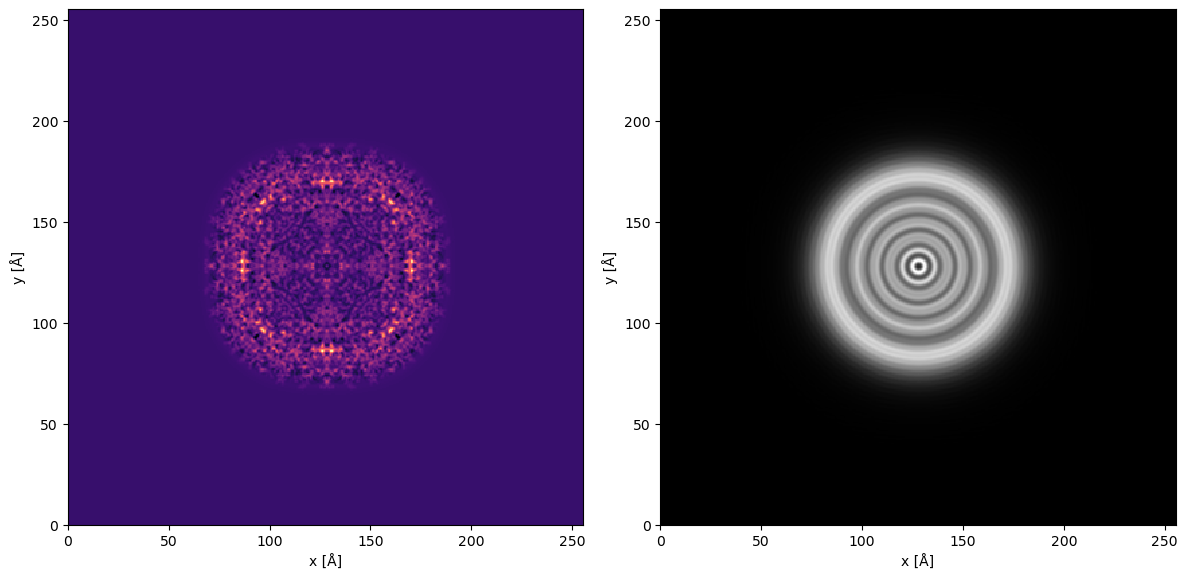

In [4]:
binned_volume_xyz = embedded_potential_array_xyz.reshape((
        res,
        res,
        res//bin_factor_z,
        bin_factor_z
    )).sum(-1)

binned_volume_zxy = binned_volume_xyz.transpose(2,0,1) # abtem expects the first dimension to be z

potential = abtem.PotentialArray(
    binned_volume_zxy,
    slice_thicknesses=pixel_size*bin_factor_z,
    sampling=(pixel_size,pixel_size),
)

probe = abtem.Probe(
    energy=energy,
    ctf=abtem.CTF(
        semiangle_cutoff=semiangle,
        rolloff=rolloff,
        parameters={'C10':-defocus,'C12':astigmatism,'phi12':astigmatism_angle}
    ),
    device='gpu',
)
probe.match_grid(potential)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
(potential.project()* abtem.utils.energy2sigma(energy)).show(
    ax=ax1,
    cmap='magma',
)

probe.show(ax =ax2);

fig.tight_layout()

### Random Orientations

We want to place multiple, randomly orientated, apoferritin samples in the field of view - so we write a simple utility to rotate, bin, and tranpose the volume.

In [5]:
def rotate_xyz_volume(
    volume_array,
    rot_matrix,
    order=3,
):
    """ 3D volume rotation using spline interpolation """
    
    volume = volume_array.copy()
    volume_shape = cp.asarray(volume.shape)
    tf = cp.asarray(rot_matrix.T)
    
    in_center = (volume_shape - 1) / 2
    out_center = tf @ in_center
    offset = in_center - out_center
    
    volume = affine_transform(volume,tf,offset=offset,order=order,cval=3.6) # ice-voltage
    
    return volume

def randomly_rotate_volume(vol,seed=None):
    """ rotate, bin, and transpose volume """
    rot_mat = Rotation.random(random_state=seed).as_matrix()
    rotated_volume = rotate_xyz_volume(vol,rot_mat)
    resized_volume = rotated_volume.reshape((
        res,
        res,
        res//bin_factor_z,
        bin_factor_z
    )).sum(-1)
    return resized_volume.transpose(2,0,1)

def potential_and_probe(vol,seed=None):
    """ return rotated potential array and probe """
    rotated_vol = randomly_rotate_volume(vol,seed)
    
    potential = abtem.PotentialArray(
        rotated_vol,
        slice_thicknesses=pixel_size*bin_factor_z,
        sampling=(pixel_size,pixel_size),
    )
    
    probe = abtem.Probe(
        energy=energy,
        ctf=abtem.CTF(
            semiangle_cutoff=semiangle,
            rolloff=rolloff,
            defocus=defocus
        ),
        device='gpu',
    )
    probe.match_grid(potential)

    return potential,probe

Let's plot two random projections:

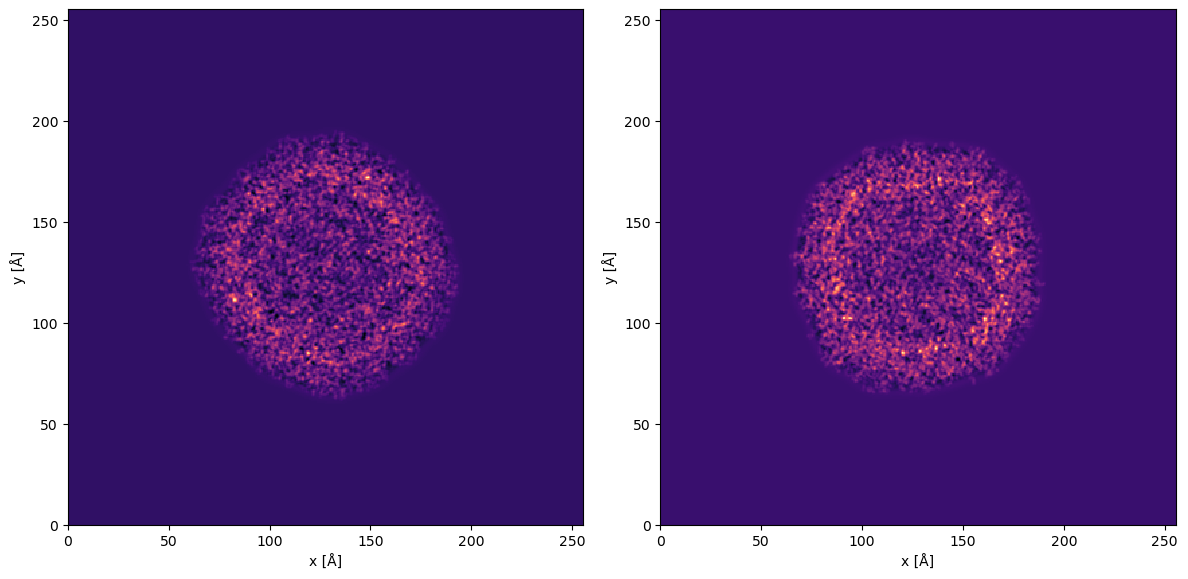

In [6]:
embedded_potential_array_xyz_cp = cp.asarray(embedded_potential_array_xyz)
potential_01, _ = potential_and_probe(embedded_potential_array_xyz_cp)
potential_02, _ = potential_and_probe(embedded_potential_array_xyz_cp)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
potential_01.project().show(
    ax=ax1,
    cmap='magma',
)

potential_02.project().show(
    ax=ax2,
    cmap='magma',
)

fig.tight_layout()

### Simulation
Since these are so large (and surrounded by a constant potential), we will simulate them one at a time.

In [7]:
num_probes_per_particle = 24
bin_factor = 2

pixelated_detector = abtem.PixelatedDetector(
    max_angle="limit",
)

grid_scan = abtem.GridScan(
    (0, 0),
    (res*pixel_size,res*pixel_size),
    gpts=(num_probes_per_particle+1,num_probes_per_particle+1),
    endpoint=True,
)

def binned_array_from_seed(seed=None,rotation_deg=None):
    potential,probe = potential_and_probe(embedded_potential_array_xyz_cp,seed)
    measurement = probe.scan(
        grid_scan,
        pixelated_detector,
        potential,
        pbar=False,
    ).array

    if rotation_deg is not None:
        measurement = rotate(measurement,rotation_deg,reshape=False,axes=(-2,-1),order=1)

    sx,sy,qx,qy = measurement.shape
    measurement = measurement.reshape((
        sx,
        sy,
        qx//bin_factor,
        bin_factor,
        qy//bin_factor,
        bin_factor
    )).sum((3,5))

    # np.random.seed(seed)
    # noisy_array = np.random.poisson((measurement * electron_dose_per_probe).clip(0)).astype(np.uint16)

    return measurement

We initialize a large fov to include a 4x4 grid of proteins and start the simulation loop:

In [8]:
n = 3
tx = ty = n*num_probes_per_particle+1
large_4ddataset =np.zeros((tx,ty,res//3*2//bin_factor,res//3*2//bin_factor),dtype=np.float32)

for ix, iy in tqdmnd(n,n):
    seed = ix*n+iy
    binned_array = binned_array_from_seed(seed,15)
    large_4ddataset[
        ix*num_probes_per_particle:(ix+1)*num_probes_per_particle+1,
        iy*num_probes_per_particle:(iy+1)*num_probes_per_particle+1
    ] = binned_array

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.22s/it]


### Save Simulations
Finally, we save our simulated dataset

In [9]:
dc = py4DSTEM.DataCube(large_4ddataset)
dc.calibration.set_R_pixel_size(grid_scan.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(probe.angular_sampling[0] * bin_factor) 
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.1538085070134974
             R_pixel_size:    10.666666666666666
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

In [10]:
py4DSTEM.save("data/parallax_apoferritin_simulation.h5",dc,mode='o')